In [19]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('datasets/merged.csv')

from sklearn.model_selection import train_test_split

df = df.dropna(subset=["zhvi_2021"])

X_cols = ["B01003_001E", "B08134_001E", "B15012_001E", "B19013_001E", "B23025_005E", "B25001_001E", "B25002_002E", "ALAND", "AWATER", "INTPTLAT", "INTPTLONG"]
y_cols = ["zhvi_2021"]

X_train, X_test, y_train, y_test = train_test_split(
    df[X_cols], df[y_cols], test_size=0.25, random_state=42)

### Define custom dataset class

In [20]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = lambda x: torch.tensor(x, dtype=torch.float32)
        self.target_transform = lambda y: torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        features = self.X[idx, :]
        label = self.y[idx, :]
        features = self.transform(features)
        label = self.target_transform(label)

        return features, label

In [21]:
if torch.backends.mps.is_available():
  device = "mps"
elif torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(device)

cpu


### Normalization

In [22]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_normalized = scaler_X.fit_transform(X_train)
y_train_normalized = scaler_y.fit_transform(y_train)

X_test_normalized = scaler_X.transform(X_test)
y_test_normalized = scaler_y.transform(y_test)

### Data loader

In [23]:
train_dataset = HousingDataset(X_train_normalized, y_train_normalized)
test_dataset = HousingDataset(X_test_normalized, y_test_normalized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear Regression

In [24]:
from torch import nn
import torch.nn.functional as F

class LinearRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearRegression, self).__init__()

        # Define the layers of the neural network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Define the activation function for the hidden layer (here we're using ReLU)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Construct model, loss function, and optimizer

In [25]:
input_size = len(X_cols)
hidden_size = 64
output_size = 1

model = LinearRegression(len(X_cols), 1000, 1)
loss_fn = nn.MSELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
from matplotlib import pyplot as plt

def training_loop(model, train_dataloader, val_dataloader, learning_rate, epochs):
    train_size = len(train_dataloader.dataset)
    val_size = len(val_dataloader.dataset)

    train_loss_history = []
    val_loss_history = []

    for t in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        for batch, (X, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            pred = model(X)
            fit = loss_fn(pred, y)
            train_loss += fit.item() / train_size

            # Backpropagation
            fit.backward()
            optimizer.step()

        train_loss_history += [train_loss]

        for batch, (X, y) in enumerate(val_dataloader):
            with torch.no_grad():
                pred = model(X)
                fit = loss_fn(pred, y)
                val_loss += fit.item() / val_size

        val_loss_history += [val_loss]

        if t % 50 == 0:
            print(f"epoch {t}: val_loss = {val_loss}")

    return train_loss_history, val_loss_history

def plot_histories(tlh, vlh):
    fig, ax = plt.subplots()

    ax.plot(tlh, label="train")
    ax.plot(vlh, label="validation")
    ax.legend()
    ax.set(xlabel="epoch", title="loss")
    ax.semilogy()

epoch 0: val_loss = 0.009221800362432237
epoch 50: val_loss = 0.006391313741143965
epoch 100: val_loss = 0.005906756478824364
epoch 150: val_loss = 0.005945645001353017
epoch 200: val_loss = 0.005816502365844931
epoch 250: val_loss = 0.0056528358960783245
epoch 300: val_loss = 0.005988545251997891
epoch 350: val_loss = 0.005844944764841472
epoch 400: val_loss = 0.006121396569424118
epoch 450: val_loss = 0.005830779143713958


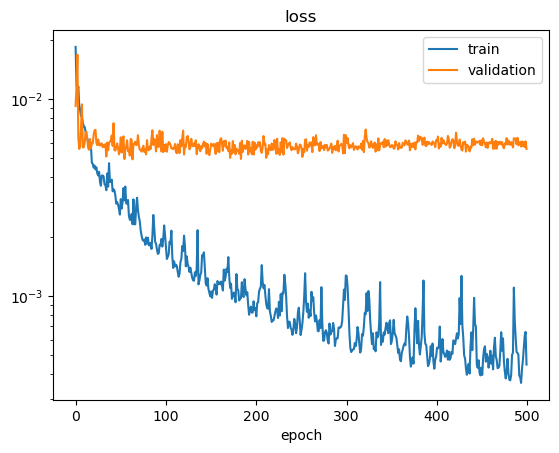

In [27]:
tlh, vlh = training_loop(model, train_loader, test_loader, 1e-4, 500)
plot_histories(tlh, vlh)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model(torch.tensor(X_test.values, dtype=torch.float)).detach().numpy()
print(f"Score: {r2_score(y_test, y_pred):.4g}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: -5.621e+07
MSE: 1.01383e+18
